## Supervised Learning
## Project: Finding Donors for *CharityML*

## Intro

Welcome to my project, where I'll be employing several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. Throughout this journey, I will choose the algorithms, identify the best candidate, and further optimize it to construct a model that predicts whether an individual makes more than $50,000.

The primary goal of this implementation is to create a model with practical applications, particularly in non-profit settings that rely on donations. Understanding an individual's income becomes crucial for non-profits, helping them gauge the appropriate donation amount to request and determine whether outreach efforts are warranted. While extracting an individual's general income bracket directly from public sources might be challenging, I'll demonstrate how this value can be inferred from other publicly available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income), generously donated by Ron Kohavi and Barry Becker. It was initially published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_ by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). Throughout this exploration, you'll notice modifications made to the original dataset, such as the removal of the 'fnlwgt' feature and exclusion of records with missing or ill-formatted entries. Join me on this exciting journey into algorithmic modeling and data optimization, with the potential to make a meaningful impact on decision-making in non-profit scenarios.

----
## Exploring the Data


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will be computing the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.



In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k/n_records*100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 



C:\Users\naste\OneDrive\DA nanodegree\ML\supervised\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


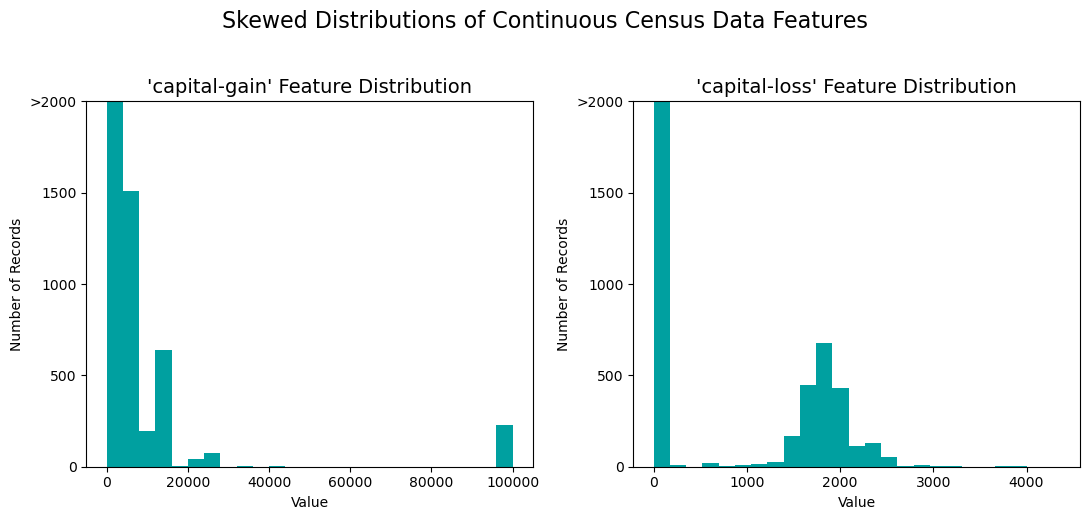

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


C:\Users\naste\OneDrive\DA nanodegree\ML\supervised\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


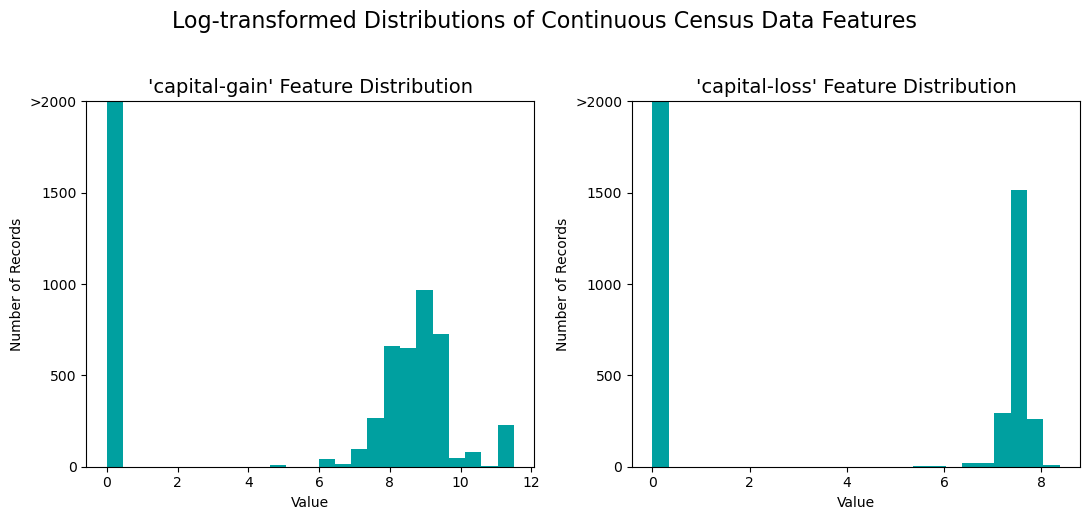

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.



In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will be implementing the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.



In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                     
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most 50,000, and those who make more), it's clear most individuals do not make more than 50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than 50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
TP = np.sum(income) 
# Specific to the naive case
FP = income.count() - TP 
# No predicted negatives in the naive case
TN = 0 
# No predicted negatives in the naive case
FN = 0

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models


###  Model Application
There is a list of three of the supervised learning models that are appropriate for this problem that we will test on the census data. 


1. AdaBoost (Adaptive Boosting):

- Real-world application: AdaBoost can be applied in face detection systems, where the goal is to accurately classify images as containing a face or not. It combines multiple weak classifiers to form a strong classifier that can effectively identify faces in various conditions.

- Strengths: AdaBoost is robust to overfitting and can handle complex datasets with high dimensionality. It performs well even with weak learners (classifiers that perform slightly better than random guessing). It can capture both linear and non-linear relationships between features.

- Weaknesses: AdaBoost is sensitive to noisy data and outliers. If the weak learners are too complex or overfit the training data, it can lead to poor performance. It may also be computationally expensive.

- Candidate's strenght: AdaBoost is a good candidate for this problem because it can handle high-dimensional data, capture complex relationships, and effectively classify individuals into income groups by combining multiple weak learners.

2. Support Vector Machines (SVM):

- Real-world application: SVM has been widely used in various industries, including text classification, image recognition, and bioinformatics. For example, SVM can be used in text classification to classify emails as spam or non-spam by learning from the textual features of emails.

- Strengths: SVM performs well in high-dimensional spaces and is effective in cases where the number of features is larger than the number of samples. It can handle both linear and non-linear classification using different kernel functions. SVM aims to find the maximum margin decision boundary, often leading to good generalization performance.

- Weaknesses: SVM can be sensitive to the choice of hyperparameters, such as the kernel type and regularization parameter. It can also be computationally expensive for large datasets and requires careful handling of missing data and categorical variables.

- Candidate's strenght: SVM suits this problem because it can handle numerical and categorical features. Using appropriate kernel functions, SVM can capture non-linear relationships between features and the target variable.

3. Logistic Regression:

- Real-world application: Customer churn prediction in the telecom industry. Logistic Regression can be used to predict the likelihood of customers canceling their subscriptions based on factors such as usage patterns, customer demographics, and service interactions.

- Strengths: Logistic Regression is a simple and interpretable model. It performs well with binary classification problems and can handle both categorical and numerical features. It can provide probability estimates and can be easily updated with new data.

- Weaknesses: Logistic Regression assumes a linear relationship between features and the log odds of the target variable. It may not capture complex interactions or non-linear relationships between features.

- Candidate's strenght: Logistic Regression is a good candidate for this problem because it can handle both categorical and numerical features. It provides a good balance between simplicity and interpretability. Given that the goal is to predict whether an individual makes more than $50,000 (a binary classification problem), Logistic Regression can provide probability estimates that can be used to make informed decisions.


#### Resources
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier<br>
https://learn.udacity.com/nanodegrees/nd002-wgu-5/parts/6967d048-b31a-4f2c-8f21-c4db11c91a22/lessons/3c0ccd08-211e-4647-8c9c-6b42d2b02bfa/concepts/29114b94-22b3-4ad8-953e-a0c7acef1143<br>
https://www.capitalone.com/tech/machine-learning/what-is-logistic-regression/<br>

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important to create a training and predicting pipeline that allows to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.
In the code block below, we will be implementing the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


C:\Users\naste\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


C:\Users\naste\DA nanodegree\ML\supervised\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


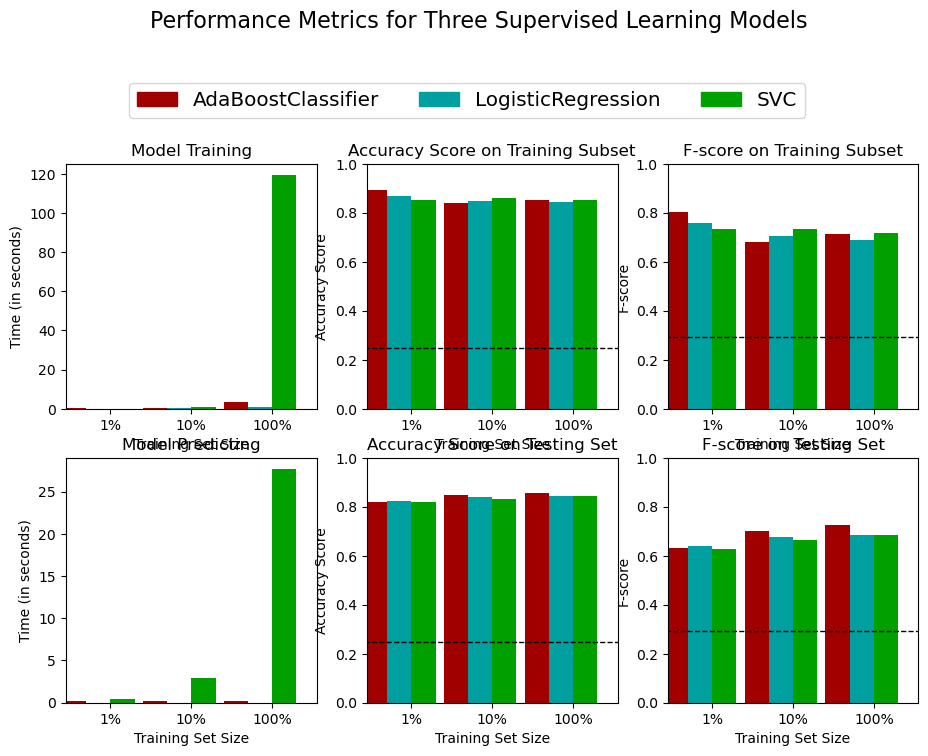

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# Initialize the three models
clf_A = AdaBoostClassifier(random_state = 42)
clf_B = LogisticRegression(random_state = 42)
clf_C = SVC(random_state = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results


### Choosing the Best Model



Based on the evaluation results, the AdaBoost model is the most appropriate for identifying individuals who make more than $50,000. When 100% of the training data is used, AdaBoost achieves the highest F-score on the testing set, indicating its effectiveness in classifying individuals accurately.

In terms of prediction and training time, AdaBoost performs reasonably well. Although training takes slightly more time than Logistic Regression, the overall time is still within an acceptable range. The additional time spent in training is justified by the improved performance of AdaBoost in terms of accuracy and F-score.

Considering the nature of the data and the problem at hand, AdaBoost is a good fit. It can handle high-dimensional data, capture complex relationships, and effectively classify individuals into income groups. It leverages the strength of multiple weak learners to form a strong classifier, which makes it robust and suitable for this classification task.


### Describing the Model in Layman's Terms



The final model is AdaBoost, which stands for Adaptive Boosting. Imagine having a group of people trying to solve a problem together. Each group member is a weak learner, meaning they are not very good at solving the problem individually. However, when all these people work together and combine their knowledge, they become a strong team that can solve the problem effectively. 

During the training phase of AdaBoost, the model looks at the data and tries to identify patterns or rules that can help predict whether an individual makes more than $50,000. It starts by assigning equal importance to each individual (weak learner) in the group. It then focuses on the individuals it didn't predict correctly and gives them more importance. In the next round, the model pays extra attention to these individuals and tries to make better predictions for them. This process continues for several rounds, with the model adjusting its focus to the most challenging individuals in each round.

Once the training is complete, AdaBoost combines the knowledge of all the weak learners and creates a strong model that can make predictions. When a new individual's information is given to the model, it checks what the weak learners think about that person based on their individual knowledge. The model then combines these opinions and decides whether the person makes more than $50,000.

### Implementation: Model Tuning
To fine tune the chosen model we use the grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. In the code cell below, we will be implementing the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.



In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Initialize the classifier
clf = AdaBoostClassifier(random_state = 42)

# Create the parameters list you wish to tune, using a dictionary if needed.

parameters = {'n_estimators': [50, 100, 600],
              'learning_rate': [0.1, 0.5, 1.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8660
Final F-score on the testing data: 0.7415


### Final Model Evaluation


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8576               |    0.8660             |
| F-score        |    0.7246               |   0.7415       |


The optimized model's accuracy on the testing data is 0.8660, and the F-score is 0.7415. These scores are slightly better than the unoptimized model, where the accuracy was 0.8576, and the F-score was 0.7246. The optimization process helped improve the performance of the model.

Compared to the naive predictor benchmarks, the results from the optimized model are significantly better. The naive predictor had an accuracy score of 0.2478 and an F-score of 0.2917. The optimized model demonstrates a substantial improvement over the naive predictor, indicating that it is a much more effective model for identifying individuals who make more than $50,000.

----
## Feature Importance



### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

Among the thirteen available features, the five most important features for prediction, ranked in order, are as follows:

1. The occupation an individual holds can have a significant impact on their income. Certain professions, such as doctors, lawyers, or executives, tend to offer higher salaries compared to other occupations. Therefore, occupation can be a strong predictor of income.

2. Education plays a crucial role in determining an individual's income. Higher education levels often lead to better job opportunities and higher salaries. Therefore, the education level is likely to be a strong predictor of income.

3. Age can be an important factor as individuals tend to earn higher incomes as they gain more experience and progress in their careers. Older individuals may have had more time to accumulate wealth and establish themselves professionally.

4. Capital gain represents the profit from the sale of assets such as stocks, real estate, or businesses. Higher capital gains indicate higher levels of investment and financial success, which can contribute significantly to an individual's income.

5. The number of hours worked per week is an essential factor in determining income. Generally, individuals who work more hours have the potential to earn higher incomes, as they have more opportunities for overtime pay or higher wages.



### Implementation - Extracting Feature Importance


In the code cell below, we will be implementing the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

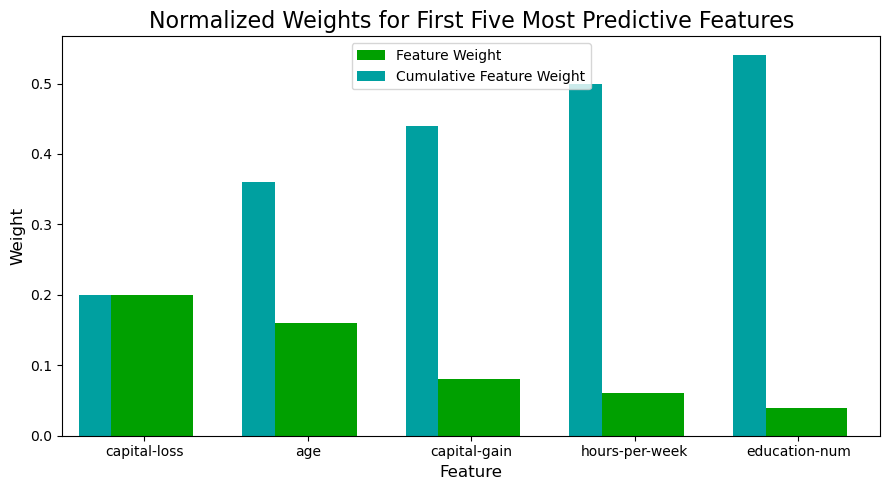

In [12]:
# Import a supervised learning model that has 'feature_importances_'

from sklearn.metrics import f1_score

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=42,).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance



Comparing my initial thoughts to the feature importance visualization, age and hours per week are indeed among the top five most relevant features. This confirms my intuition that age and the number of hours worked per week are strong predictors of income.

However, the visualization suggests that capital loss and capital gain are more relevant features than occupation. This indicates that the financial aspects related to capital gains and losses significantly impact an individual's income. Additionally, the visualization highlights education_num (number of educational years completed) as an important feature, which aligns with the initial consideration of education_level; I agree that the completed academic years' number will better describe a person that education level(e.g., "some college" educational level can belong to people who finish one course and three courses)

The feature importances derived from the AdaBoost model provide an objective measure of the relevance of each feature for prediction. It indicates that financial factors related to capital gains and losses, along with education and work-related factors such as age and hours per week, play a crucial role in predicting an individual's income.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8660
F-score on testing data: 0.7415

Final Model trained on reduced data
------
Accuracy on testing data: 0.8427
F-score on testing data: 0.7048


### Effects of Feature Selection



#### Results:

|     Metric     | Final Model trained on full data | Final Model trained on reduced data |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8660               |    0.8427             |
| F-score        |    0.7415               |   0.7048       |

The scores obtained on the reduced data using only five features are slightly lower than the scores obtained when all features are used. This suggests that the reduced feature space has a minor negative impact on the model's performance.

However, it is important to consider the trade-off between performance and training time. If training time is, a crucial factor and the slight decrease in performance is acceptable, using the reduced data as the training set can be considered. The training time can be significantly reduced using fewer features without substantially decreasing the model's overall performance.

Therefore, if training time is a critical constraint, using the reduced data as the training set can be a reasonable choice. However, if achieving the highest possible performance is of utmost importance and computational resources are not a concern, using the full data with all features is preferable.
